
------

# Meassuring Performance
## Exercise #1

In this exercise you will meassure the perfromane of `histogram.cpp`. A **histogram** is a graph used to represent the frequency distribution of a few data points of one variable. Histograms often classify data into various "bins" or "range groups" and count how many data points belong to each of those bins.

This simple program `histogram.cpp` will create a histogram of several data points and meassure the time it takes to execute it sequentially (`Tseq`)

In [2]:
%%writefile histogram.cpp

#include <cstdlib>
#include <iostream>
#include <time.h>
#include <chrono>
#include <iomanip>

#define MAX_SIZE 1000000000
#define BINS 10
#define MAX(a,b) (((a)>(b))?(a):(b))

using namespace std;
using namespace std::chrono;

int main(int argc, char const *argv[]) {
    int n = 10;
    // Declaring data as static allows for biger array sizes
    static int data[MAX_SIZE];
    double seq_durations[9];
    int row = 0;
    
    // SVP: Initialized the seed only once in the main() function 
    // for the rand() in the sequential version of the fucntion.
    srand(time(NULL));

    cout << "Processing histogram sequentially..." << endl;
    
    while (n <= MAX_SIZE)
    {
        // Histogram will contain 10 bins 
        int histogram[BINS] = {0};
        
        cout << "  calculating histogram for " <<  n << " elements" << endl;
        
        // start timing 
        auto start = high_resolution_clock::now();

        // Generate random data points from 0 to 9
        for (int i = 0; i < n; ++i)
            data[i] = rand() % 10;

        // Organize data by placing data points
        // into corresponding bins
        for (int i = 0; i < n; ++i)
        {
            int point = data[i];
            histogram[point]++;
            // or
            // histogram[data[i]]++;

        }

        // stop timing 
        auto stop = high_resolution_clock::now();
        // Get duration. Substart timepoints to
        // get duration. To cast it to proper unit
        // use duration cast method
        auto duration = duration_cast<microseconds>(stop - start);
        
        seq_durations[row++] = duration.count()/1000000.0;
        
        // Increase the size of the data 10 folds
        n *= 10;

    }
    
    cout << endl << "Done!" <<  endl << "Printing results: " << endl << endl;
        
    row = 0;
    ostringstream ss;
    ss << std::setw( 12 ) << setfill( ' ' ) << left << "n (size)";
    ss << "time (s)" << endl;
    
    for (int i = 10; i <= MAX_SIZE; i *= 10)
    {
        ss << setw( 12 ) << setfill( ' ' ) << left << i;
        ss << seq_durations[row++] << endl;
    }
    
    cout << ss.str();

    return 0;
}



Overwriting histogram.cpp


In [3]:
!g++ histogram.cpp -o histogram -pedantic -Wall

In [4]:
!./histogram

Processing histogram sequentially...
  calculating histogram for 10 elements
  calculating histogram for 100 elements
  calculating histogram for 1000 elements
  calculating histogram for 10000 elements
  calculating histogram for 100000 elements
  calculating histogram for 1000000 elements
  calculating histogram for 10000000 elements
  calculating histogram for 100000000 elements
  calculating histogram for 1000000000 elements

Done!
Printing results: 

n (size)    time (s)
10          2e-06
100         3e-06
1000        2.8e-05
10000       0.000205
100000      0.002077
1000000     0.012784
10000000    0.109844
100000000   1.09698
1000000000  10.8249



-------

## Parallel Histogram

Now we have the parallel version of the histogram program `para_histogram.cpp` which will calculate the histogram of datasets of different sizes (`n`), using an increasing number of processing units (**threads** in the case of this program). Run the cell below to see the parallel execution time (`Tpar`) for datasets of sizes 10 to 1,000,000,000 using 1, 2, 4, 8, 16, 32, 64, 128, 256, and 512 threads.

In [5]:
%%writefile para_histogram.cpp

#include <cstdlib>
#include <iostream>
#include <chrono>
#include <iomanip>
#include <string> 
#include <time.h>
#include <omp.h>

#define MAX_SIZE 1000000000
#define BINS 10
#define MAX(a,b) (((a)>(b))?(a):(b))
#define MAX_THREADS 512

using namespace std;
using namespace std::chrono;

int main(int argc, char const *argv[]) {
    int n = 10;
    // Declaring data as static allows for biger array sizes
    static int data[MAX_SIZE];
    double par_durations[9][10] = {0.0};
    int row = 0, col = 0;
    int threads = 1;
    
    // SVP: Initialized the seed only once in the main() function 
    // for the rand() in the sequential version of the fucntion.
    srand(time(NULL));

    cout << "Processing histogram in parallel..." << endl;
    

    while (threads <= MAX_THREADS){
        cout << "  Using " <<  threads << " threads" << endl << endl;
        
        n = 10;
        while (n <= MAX_SIZE)
        {
            int t_histogram[BINS] = {0};
            
            double start_time = omp_get_wtime();
            
            #pragma omp parallel num_threads(threads)
            {
                // Initialize a seed for each individual thread. 
                unsigned int seed = 42 + omp_get_thread_num();
                int t_point;

                #pragma omp for
                for (int i = 0; i < n; i++) {
                    // Substitute the rand() function which is not thread safe for the thread-safe version rand_r(seed)
                    t_point = rand_r(&seed) % 10;
                    data[i] = t_point;
                }

        
                #pragma omp for reduction(+:t_histogram[:10])
                for (int i = 0; i < n; ++i) {
                    t_point = data[i];
                    t_histogram[t_point]++;
                }
            }
            double duration = omp_get_wtime() - start_time;
            par_durations[row][col] = duration;
            
            row++;
            n *= 10;
        }
        
        threads *= 2;
        row = 0;
        col++;

    }
    
    cout << endl << "Done!" <<  endl << "Printing results: col = " << col << endl << endl;
        
    row = 0;
    ostringstream ss, to_csv;
    ss << setw( 11 ) << setfill( ' ' ) << left << "n (size)";
    
    for (int t = 1; t <= MAX_THREADS; t *= 2)
    {
        string thr = "T=" + to_string(t) + " (s)";
        ss << std::setw( 11 ) << setfill( ' ' ) << left << thr;
    }

    ss << endl;
    to_csv << "n,T=1,T=2,T=4,T=8,T=16,T=32,T=64,T=128,T=256,T=512\\n";
    
    for (int i = 10; i <= MAX_SIZE; i *= 10)
    {
        ss << setw( 11 ) << setfill( ' ' ) << left << i;
        to_csv << i;
        
        for (int c = 0; c < col; c++)
        {
            ss << setw( 11 ) << setfill( ' ' ) << left << par_durations[row][c];
            to_csv << "," << par_durations[row][c]; 
        }
        
        ss << endl;
        to_csv << "\\n";
        
        row++;
    }
    
    cout << ss.str() << endl;;
    cout << to_csv.str();

    return 0;
}

Overwriting para_histogram.cpp


In [6]:
!g++ -fopenmp para_histogram.cpp -o para_histo -pedantic -Wall

In [7]:
!./para_histo

Processing histogram in parallel...
  Using 1 threads

  Using 2 threads

  Using 4 threads

  Using 8 threads

  Using 16 threads

  Using 32 threads

  Using 64 threads

  Using 128 threads

  Using 256 threads

  Using 512 threads


Done!
Printing results: col = 10

n (size)   T=1 (s)    T=2 (s)    T=4 (s)    T=8 (s)    T=16 (s)   T=32 (s)   T=64 (s)   T=128 (s)  T=256 (s)  T=512 (s)  
10         3.08771e-050.0001603940.0001788710.0002748020.0003038480.00055841 0.00117379 0.00211146 0.0047046  0.00775658 
100        5.78398e-061.46162e-051.28979e-051.72649e-052.0979e-05 5.19389e-050.0004600520.0007004790.00135267 0.00247887 
1000       1.99638e-052.61399e-052.97879e-055.56107e-052.08011e-054.8059e-05 0.0004804660.0008188530.00136343 0.00248994 
10000      0.0001534650.0001381348.71778e-055.42323e-056.1098e-05 5.00339e-050.0003501080.0007641890.00137662 0.00249915 
100000     0.00153124 0.00129235 0.0007613940.0003781320.0001698890.0001104550.00056849 0.0007797840.00118158 0.00267951


-----

## Vizualizing Results

Now, copy the comma-separated list of results that you obtained from running the `para_histogram.cpp`, the one that start with `n,T=1,T=2,T=4,T=8,T=16,T=32,T=64,T=128,T=256,T=512\n...`, and paste it in the second line of the cell below, execute it to make a CSV file to generate a chart with the parallel execution times of your choosing.

In [97]:
f = open('results_parallel.csv','w')
f.write('PASTE THE COMMA-SEPARATED VAUES HERE') #Give your csv values here.
## Python will convert \n to os.linesep
f.close()

            n        T=1       T=2       T=4       T=8      T=16      T=32  \
0          10   0.000038  0.000210  0.000259  0.000188  0.000356  0.001428   
1         100   0.000007  0.000008  0.000010  0.000010  0.000023  0.000058   
2        1000   0.000034  0.000034  0.000051  0.000015  0.000019  0.000046   
3       10000   0.000192  0.000158  0.000108  0.000046  0.000032  0.000050   
4      100000   0.001927  0.001491  0.000795  0.000329  0.000176  0.000105   
5     1000000   0.019054  0.013897  0.007336  0.003225  0.001709  0.000814   
6    10000000   0.166111  0.118210  0.061225  0.031372  0.014873  0.010539   
7   100000000   1.144770  0.549252  0.430555  0.203945  0.114199  0.065901   
8  1000000000  11.160800  5.593880  3.295270  1.969940  1.019900  0.449069   

       T=64     T=128     T=256     T=512  
0  0.000981  0.002006  0.003795  0.007956  
1  0.000349  0.000676  0.001127  0.002299  
2  0.000404  0.000493  0.001138  0.002265  
3  0.000314  0.000687  0.000935  0.002397  

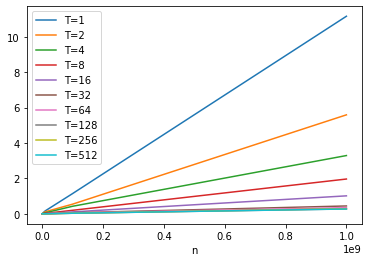

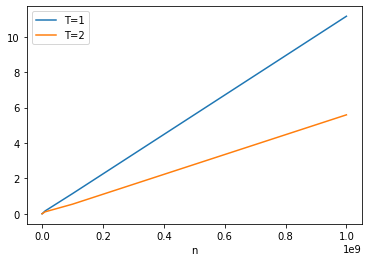

In [8]:
#import library
import pandas as pd

#add csv file to dataframe
df = pd.read_csv('results_parallel.csv')

print (df)

#create line graphgra
bargraph = df.plot.line(x = 'n')

#to plot T=1 vs T=2
bargraph = df.plot.line(x = 'n', y=['T=1', 'T=2'])


## Calculate Speedup and Efficiency

You will use the results of `Tpar` to calculate **Speedup** and **Efficiency** of `para_histogram.cpp`